In [3]:
%matplotlib inline

# 📝  Pytorch Quickstart, a deep learning framework for Python 🤖

## An Engineering Approach to Deep Learning

As an engineer we are often expected to use tools without fully understanding them. This is unfortunate, but it is a reality. The alternative is being a mathematician who spends their time exploring minutiae of the theory without doing anything of practical imporance towards a task. 

This section runs through the API for common tasks in machine learning. Refer to the links in each section to dive deeper.

Adapted from [Pytorch Quickstart](https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html)

```{note}
Neural networks generally require a GPU to train. Our server does not have a GPU because they are expensive to run. You can get access to free GPU resource to run this Notebook:

[Google Colab](https://colab.research.google.com/notebooks/intro.ipynb)
[NRP JupyterHub](https://jupyterhub-west.nrp-nautilus.io/)

```


## Working with data
PyTorch has two [primitives to work with data](https://pytorch.org/docs/stable/data.html):
``torch.utils.data.DataLoader`` and ``torch.utils.data.Dataset``.
``Dataset`` stores the samples and their corresponding labels, and ``DataLoader`` wraps an iterable around
the ``Dataset``.


In [5]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from matplotlib import pyplot as plt
import numpy as np

PyTorch offers domain-specific libraries such as [TorchText](https://pytorch.org/text/stable/index.html),
[TorchVision](https://pytorch.org/vision/stable/index.html), and [TorchAudio](https://pytorch.org/audio/stable/index.html),
all of which include datasets. For this tutorial, we  will be using a TorchVision dataset.



The ``torchvision.datasets`` module contains ``Dataset`` objects for many real-world vision data like
CIFAR, COCO ([full list here](https://pytorch.org/vision/stable/datasets.html)). In this tutorial, we
use the FashionMNIST dataset. Every TorchVision ``Dataset`` includes two arguments: ``transform`` and
``target_transform`` to modify the samples and labels respectively.



In [6]:
# Download training data from open datasets
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),  # Converts images to PyTorch tensors
)

# Download test data from open datasets
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),  # Converts images to PyTorch tensors
)

100%|██████████| 26.4M/26.4M [00:01<00:00, 16.5MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 362kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 6.75MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 11.4MB/s]


We pass the ``Dataset`` as an argument to ``DataLoader``. This wraps an iterable over our dataset, and supports
automatic batching, sampling, shuffling and multiprocess data loading. Here we define a batch size of 64, i.e. each element
in the dataloader iterable will return a batch of 64 features and labels.



In [7]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


Read more about [loading data in PyTorch](data_tutorial.html).




## Creating Models
To define a neural network in PyTorch, we create a class that inherits
from [nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html). We define the layers of the network
in the ``__init__`` function and specify how data will pass through the network in the ``forward`` function. To accelerate
operations in the neural network, we move it to the GPU if available.



In [8]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model


class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


model = NeuralNetwork().to(device)
print(model)

Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


Read more about [building neural networks in PyTorch](buildmodel_tutorial.html).




## Optimizing the Model Parameters
To train a model, we need a [loss function](https://pytorch.org/docs/stable/nn.html#loss-functions)
and an [optimizer](https://pytorch.org/docs/stable/optim.html).



In [9]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In a single training loop, the model makes predictions on the training dataset (fed to it in batches), and
backpropagates the prediction error to adjust the model's parameters.



In [10]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

We also check the model's performance against the test dataset to ensure it is learning.



In [11]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(
        f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n"
    )

The training process is conducted over several iterations (*epochs*). During each epoch, the model learns
parameters to make better predictions. We print the model's accuracy and loss at each epoch; we'd like to see the
accuracy increase and the loss decrease with every epoch.



In [12]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.299250  [    0/60000]
loss: 2.282714  [ 6400/60000]
loss: 2.263988  [12800/60000]
loss: 2.265477  [19200/60000]
loss: 2.231801  [25600/60000]
loss: 2.215499  [32000/60000]
loss: 2.219949  [38400/60000]
loss: 2.184998  [44800/60000]
loss: 2.182687  [51200/60000]
loss: 2.145585  [57600/60000]
Test Error: 
 Accuracy: 45.7%, Avg loss: 2.138022 

Epoch 2
-------------------------------
loss: 2.155730  [    0/60000]
loss: 2.140888  [ 6400/60000]
loss: 2.077723  [12800/60000]
loss: 2.094510  [19200/60000]
loss: 2.025862  [25600/60000]
loss: 1.975015  [32000/60000]
loss: 1.999543  [38400/60000]
loss: 1.919724  [44800/60000]
loss: 1.932649  [51200/60000]
loss: 1.840579  [57600/60000]
Test Error: 
 Accuracy: 56.7%, Avg loss: 1.842157 

Epoch 3
-------------------------------
loss: 1.887067  [    0/60000]
loss: 1.855776  [ 6400/60000]
loss: 1.726815  [12800/60000]
loss: 1.765190  [19200/60000]
loss: 1.643301  [25600/60000]
loss: 1.604265  [32000/600

Read more about [Training your model](optimization_tutorial.html).




## Saving Models
A common way to save a model is to serialize the internal state dictionary (containing the model parameters).



In [13]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


## Loading Models

The process for loading a model includes re-creating the model structure and loading
the state dictionary into it.



In [14]:
model = NeuralNetwork()
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

This model can now be used to make predictions.



Index: 1811
Predicted: "Shirt", Actual: "Coat"


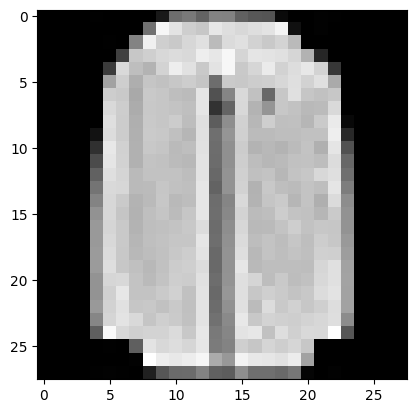

In [18]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

index = np.random.randint(0, 10000)

model.eval()
x, y = test_data[index][0], test_data[index][1]
with torch.no_grad():
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f"Index: {index}")
    print(f'Predicted: "{predicted}", Actual: "{actual}"')
    plt.imshow(x[0], cmap="gray")

Read more about [Saving & Loading your model](saveloadrun_tutorial.html).


